# 회전기계 고장 유형

1. 데이터 읽기
2. 데이터 전처리
3. 모델 설계
 
    3-1. DNN
   
    3-2. CNN
   
    3-2. RNN
   
5. 평가

## 고장 요인 
질량 불균형
- rotor의 질량 중심이 회전 중심과 일치하지 않을 때 나타나는 현상
- 비대칭적 원심력은 회전 기계에서 진동을 발생

지지 불량
- 기계의 수평이 틀어지거나 장비의 기울어짐

In [111]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [112]:
sensor1 = pd.read_csv("C:/Users/whdal/dataset/rotor/g1_sensor1.csv", names=['time', 'normal', 'type1', 'type2', 'type3'])
sensor2 = pd.read_csv("C:/Users/whdal/dataset/rotor/g1_sensor2.csv", names=['time', 'normal', 'type1', 'type2', 'type3'])
sensor3 = pd.read_csv("C:/Users/whdal/dataset/rotor/g1_sensor3.csv", names=['time', 'normal', 'type1', 'type2', 'type3'])
sensor4 = pd.read_csv("C:/Users/whdal/dataset/rotor/g1_sensor4.csv", names=['time', 'normal', 'type1', 'type2', 'type3'])


In [113]:
sensor1

,time,normal,type1,type2,type3
0,0.000000,-0.853307,-3.464579,0.555219,3.919664
1,0.000736,-0.740463,-2.448986,-0.234687,4.145351
2,0.001472,-0.138630,-1.922383,-0.009000,2.941685
3,0.002208,0.049443,-0.906790,-0.272301,2.603155
4,0.002944,-0.289088,-0.568259,-0.986978,1.361874
...,...,...,...,...,...
190213,139.996768,-1.156354,-2.696750,0.844491,-2.109427
190214,139.997504,-0.930666,-1.380241,0.919720,-2.222270
190215,139.998240,-0.554521,-2.132532,0.731647,-2.109427
190216,139.998976,-1.419655,-2.433448,1.183022,-3.087405


In [114]:
print(sensor1.shape)
print(sensor2.shape)
print(sensor3.shape)
print(sensor4.shape)

(190218, 5)
(184211, 5)
(196079, 5)
(183969, 5)


In [115]:
# sampling rate가 달라서 계측 시간이 다름
# 계측 시간을 동일화 하기 위한 선형 보간법 적용
from scipy import interpolate

x_new = np.arange(0, 140, 0.001)
y_new1 = []; y_new2 = []; y_new3 = []; y_new4 = []

cols = ['normal', 'type1', 'type2', 'type3']

for item in cols:
    f_linear1 = interpolate.interp1d(sensor1['time'], sensor1[item], kind='linear')
    y_new1.append(f_linear1(x_new))
    f_linear2 = interpolate.interp1d(sensor2['time'], sensor2[item], kind='linear')
    y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3['time'], sensor3[item], kind='linear')
    y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4['time'], sensor4[item], kind='linear')
    y_new4.append(f_linear4(x_new))

sensor1 = pd.DataFrame(np.array(y_new1).T, columns=cols)
sensor2 = pd.DataFrame(np.array(y_new2).T, columns=cols)
sensor3 = pd.DataFrame(np.array(y_new3).T, columns=cols)
sensor4 = pd.DataFrame(np.array(y_new4).T, columns=cols)
    
sensor1[sensor1['type3'].isnull()]

,normal,type1,type2,type3


In [116]:
sensor1.describe()

,normal,type1,type2,type3
count,140000.000000,140000.000000,140000.000000,140000.000000
mean,0.000154,-0.000147,0.000112,-0.000063
std,0.662102,1.679021,0.692259,1.855899
min,-1.977848,-6.188363,-1.915664,-6.745388
25%,-0.603861,-1.538706,-0.553806,-1.665756
50%,0.108722,-0.022895,-0.043120,0.395230
75%,0.578152,1.565662,0.572478,1.593754
max,1.791827,6.327469,2.098343,7.053118


In [117]:
normal_ = pd.concat([sensor1['normal'], sensor2['normal'], sensor3['normal'], sensor4['normal']], axis=1)
type1_ = pd.concat([sensor1['type1'], sensor2['type1'], sensor3['type1'], sensor4['type1']], axis=1)
type2_ = pd.concat([sensor1['type2'], sensor2['type2'], sensor3['type2'], sensor4['type2']], axis=1)
type3_ = pd.concat([sensor1['type3'], sensor2['type3'], sensor3['type3'], sensor4['type3']], axis=1)

normal_.columns = ['s1', 's2', 's3', 's4']
type1_.columns = ['s1', 's2', 's3', 's4']
type2_.columns = ['s1', 's2', 's3', 's4']
type3_.columns = ['s1', 's2', 's3', 's4']

In [118]:
print(normal_.shape)
print(type1_.shape)
print(type2_.shape)
print(type3_.shape)
normal_

(140000, 4)
(140000, 4)
(140000, 4)
(140000, 4)


,s1,s2,s3,s4
0,-0.853307,0.048823,-0.437626,-1.116226
1,-0.524588,-0.029477,-0.149817,-0.659694
2,-0.003708,-0.004751,0.280889,-0.857345
3,-0.297674,0.009673,-0.303281,-0.685318
4,-0.091203,0.096215,-0.320263,-0.303108
...,...,...,...,...
139995,-1.057411,0.587429,0.275044,0.289837
139996,-0.513635,-0.137874,-0.045973,0.131462
139997,-1.085213,0.002242,-0.164593,-0.087380
139998,-0.677177,-0.308897,0.288252,1.319862


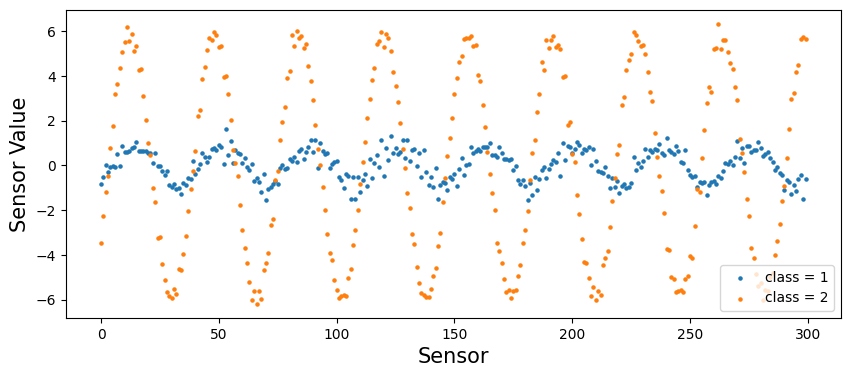

In [119]:
plt.figure(figsize=(10,4))
plt.scatter(range(0, 300), normal_[:300]['s1'], label="class = " + str(1), marker='o', s=5)
plt.scatter(range(0, 300), type1_[:300]['s1'], label="class = " + str(2), marker='o', s=5)

plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=15)
plt.ylabel("Sensor Value", fontsize=15)
plt.show()

In [120]:
normal_.corr()

,s1,s2,s3,s4
s1,1.000000,-0.007093,0.004297,-0.003377
s2,-0.007093,1.000000,-0.002992,0.111121
s3,0.004297,-0.002992,1.000000,-0.006434
s4,-0.003377,0.111121,-0.006434,1.000000


In [121]:
# raw 센서 데이터는 노이즈로 인해 AI 분석 모델 훈련에 부정적인 영향을 받음
# 이를 해결하기 위해 이동평균필터를 이용한다.

M = 15

normal_s1 = np.convolve(normal_['s1'], np.ones(M), 'valid')/M
normal_s1 = normal_s1.reshape(len(normal_s1),1)
normal_s2 = np.convolve(normal_['s2'], np.ones(M), 'valid')/M
normal_s2 = normal_s2.reshape(len(normal_s2),1)
normal_s3 = np.convolve(normal_['s3'], np.ones(M), 'valid')/M
normal_s3 = normal_s3.reshape(len(normal_s3),1)
normal_s4 = np.convolve(normal_['s4'], np.ones(M), 'valid')/M
normal_s4 = normal_s4.reshape(len(normal_s4),1)

type1_s1 = np.convolve(type1_['s1'], np.ones(M), 'valid')/M
type1_s1 = type1_s1.reshape(len(type1_s1),1)
type1_s2 = np.convolve(type1_['s2'], np.ones(M), 'valid')/M
type1_s2 = type1_s2.reshape(len(type1_s2),1)
type1_s3 = np.convolve(type1_['s3'], np.ones(M), 'valid')/M
type1_s3 = type1_s3.reshape(len(type1_s3),1)
type1_s4 = np.convolve(type1_['s4'], np.ones(M), 'valid')/M
type1_s4 = type1_s4.reshape(len(type1_s4),1)

type2_s1 = np.convolve(type2_['s1'], np.ones(M), 'valid')/M
type2_s1 = type2_s1.reshape(len(type2_s1),1)
type2_s2 = np.convolve(type2_['s2'], np.ones(M), 'valid')/M
type2_s2 = type2_s2.reshape(len(type2_s2),1)
type2_s3 = np.convolve(type2_['s3'], np.ones(M), 'valid')/M
type2_s3 = type2_s3.reshape(len(type2_s3),1)
type2_s4 = np.convolve(type2_['s4'], np.ones(M), 'valid')/M
type2_s4 = type2_s4.reshape(len(type2_s4),1)

type3_s1 = np.convolve(type3_['s1'], np.ones(M), 'valid')/M
type3_s1 = type3_s1.reshape(len(type3_s1),1)
type3_s2 = np.convolve(type3_['s2'], np.ones(M), 'valid')/M
type3_s2 = type3_s2.reshape(len(type3_s2),1)
type3_s3 = np.convolve(type3_['s3'], np.ones(M), 'valid')/M
type3_s3 = type3_s3.reshape(len(type3_s3),1)
type3_s4 = np.convolve(type3_['s4'], np.ones(M), 'valid')/M
type3_s4 = type3_s4.reshape(len(type3_s4),1)

normal_temp = np.concatenate((normal_s1,normal_s2,normal_s3,normal_s4), axis=1)
type1_temp = np.concatenate((type1_s1,type1_s2,type1_s3,type1_s4),axis=1)
type2_temp = np.concatenate((type2_s1,type2_s2,type2_s3,type2_s4),axis=1)
type3_temp = np.concatenate((type3_s1,type3_s2,type3_s3,type3_s4),axis=1)

In [122]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(normal_)
normal = scaler.transform(normal_temp)
type1 = scaler.transform(type1_temp)
type2 = scaler.transform(type2_temp)
type3 = scaler.transform(type3_temp)

C:\Users\whdal\miniconda3\envs\py3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\whdal\miniconda3\envs\py3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\whdal\miniconda3\envs\py3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\whdal\miniconda3\envs\py3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [123]:
print(normal)
print(normal.shape)

[[0.57598822 0.50553898 0.56439491 0.44551164]
 [0.60960317 0.50513674 0.58169332 0.44848001]
 [0.62990663 0.5047345  0.59547186 0.46260474]
 ...
 [0.51874981 0.50106998 0.60999194 0.50715712]
 [0.49713039 0.51588928 0.6074125  0.53093987]
 [0.45708747 0.52025039 0.60349765 0.53976513]]
(139986, 4)


In [124]:
# rotor testbed 가동 후 30초의 데이터를 탈락시키기
normal = normal[30000:130000][:]
type1 = type1[30000:130000][:]
type2 = type2[30000:130000][:]
type3 = type3[30000:130000][:]

In [125]:
# data split
normal_train=normal[:][:60000]
normal_valid=normal[:][60000:80000]
normal_test=normal[:][80000:]

type1_train=type1[:][:60000]
type1_valid=type1[:][60000:80000]
type1_test=type1[:][80000:]

type2_train=type2[:][:60000]
type2_valid=type2[:][60000:80000]
type2_test=type2[:][80000:]

type3_train=type3[:][:60000]
type3_valid=type3[:][60000:80000]
type3_test=type3[:][80000:]
train=np.concatenate((normal_train,type1_train,type2_train,type3_train))
valid=np.concatenate((normal_valid,type1_valid,type2_valid,type3_valid))
test=np.concatenate((normal_test,type1_test,type2_test,type3_test))

print("train data의 형태:", train.shape)
print("valid data의 형태:", valid.shape)
print("test data의 형태:", test.shape)

train data의 형태: (240000, 4)
valid data의 형태: (80000, 4)
test data의 형태: (80000, 4)


In [126]:
# data 라벨링

train_label = np.concatenate((np.full((60000,1),0),	np.full((60000,1),1),
                              np.full((60000,1),2),	np.full((60000,1),3)))
valid_label=np.concatenate((np.full((20000,1),0),np.full((20000,1),1),
                            np.full((20000,1),2),np.full((20000,1),3)))
test_label=np.concatenate((np.full((20000,1),0),np.full((20000,1),1),
                           np.full((20000,1),2),np.full((20000,1),3)))

In [127]:
# 데이터 shuffle
idx=np.arange(train.shape[0])
np.random.shuffle(idx)	
train=train[:][idx]
train_label=train_label[:][idx]

idx_v=np.arange(valid.shape[0])
np.random.shuffle(idx_v);	
valid=valid[:][idx_v]
valid_label=valid_label[:][idx_v]

idx_t=np.arange(test.shape[0])
np.random.shuffle(idx_t)	
test=test[:][idx_t]
test_label=test_label[:][idx_t]

In [139]:
x_train=torch.from_numpy(train).float()
y_train=torch.from_numpy(train_label).float().T[0]
x_valid=torch.from_numpy(valid).float()
y_valid=torch.from_numpy(valid_label).float().T[0]
x_test=	torch.from_numpy(test).float()
y_test=	torch.from_numpy(test_label).float().T[0]
print("변경 전")
x_train

TypeError: expected np.ndarray (got TensorDataset)

In [130]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
train=TensorDataset(x_train,y_train)
train_dataloader=DataLoader(train,batch_size=5000,shuffle=True)
valid=TensorDataset(x_valid,y_valid)
valid_dataloader=DataLoader(valid,batch_size=len(x_valid),shuffle=False)
test=TensorDataset(x_test,y_test)
test_dataloader=DataLoader(test,batch_size=len(x_valid),shuffle=False)

In [133]:
class KAMP_DNN(nn.Module):
    def	__init__(self):
        super(KAMP_DNN,	self).__init__()
        self.layer1=nn.Linear(in_features=4,out_features=100)
        self.layer2=nn.Linear(in_features=100,out_features=100)
        self.layer3=nn.Linear(in_features=100,out_features=100)
        self.layer4=nn.Linear(in_features=100,out_features=4)
        self.dropout=nn.Dropout(0.2)
        self.relu=nn.ReLU()
 
    def	forward(self,input):
        out	=self.layer1(input)
        out	=self.relu(out)
        out	=self.dropout(out)
        out	=self.layer2(out)
        out	=self.relu(out)
        out	=self.dropout(out)
        out	=self.layer3(out)
        out	=self.relu(out)
        out	=self.dropout(out)
        out	=self.layer4(out)
        return out
    
model_check=KAMP_DNN()
print(model_check)

KAMP_DNN(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


In [136]:
from torch.optim import lr_scheduler

def	train_model(model,criterion,optimizer,num_epoch,train_dataloader,PATH):
    loss_values = []
    loss_values_v = []
    check = 0
    accuracy_past = 0

    # scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
#----------------------	모델 학습---------------------#
    for	epoch in range(1, num_epochs+1):
        model.train()
        batch_number = 0
        running_loss = 0.0
        for	batch_idx, samples in enumerate(train_dataloader):
            x_train, y_train = samples
            #변수초기화
            optimizer.zero_grad()	
            y_hat = model.forward(x_train)
            loss = criterion(y_hat,y_train.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_number += 1
        loss_values.append(running_loss/batch_number)
#----------------------	모델 검증---------------------#
        model.eval()
        accuracy = 0.0
        total = 0.0
        for	batch_idx,data in enumerate(valid_dataloader):
            x_valid,y_valid = data
            v_hat = model.forward(x_valid)
            v_loss = criterion(v_hat,y_valid.long())
            _, predicted = torch.max(v_hat.data,1)
            total += y_valid.size(0)
            accuracy += (predicted==y_valid).sum().item()
        loss_values_v.append(loss.item())
        accuracy = (accuracy/total)

        # scheduler.step()
        # scheduler.step(v_loss.item())
        
#----------------Check	for	early	stopping---------------#
        if epoch%1 == 0:
            print('[Epoch{}/{}]	[Train_Loss:{:.6f}/Valid_Loss:{:.6f}]'.format(epoch, num_epochs,
                                                                              loss.item(),v_loss.item()))
            print('[Epoch{}/{}] [Accuracy:{:.6f}]'.format(epoch, num_epochs, accuracy))
        if	accuracy_past>accuracy:
            check += 1
        else:
            check = 0
            accuracy_past=accuracy
        if check > 50:
            print('Early stopping')
    torch.save(model,PATH+'model.pt')
    return	loss_values, loss_values_v

In [138]:
DNN_model=KAMP_DNN()
num_epochs=100
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(DNN_model.parameters())
PATH='C:/Users/whdal/dataset/rotor/model/'
DNN_loss_values,DNN_loss_values_v=train_model(DNN_model,criterion,optimizer,
                                              num_epochs,train_dataloader,PATH)

[Epoch1/100]	[Train_Loss:1.154422/Valid_Loss:1.119430]
[Epoch1/100] [Accuracy:0.436862]
[Epoch2/100]	[Train_Loss:0.934217/Valid_Loss:0.892576]
[Epoch2/100] [Accuracy:0.479762]
[Epoch3/100]	[Train_Loss:0.876447/Valid_Loss:0.858507]
[Epoch3/100] [Accuracy:0.485712]
[Epoch4/100]	[Train_Loss:0.870722/Valid_Loss:0.841380]
[Epoch4/100] [Accuracy:0.509875]
[Epoch5/100]	[Train_Loss:0.860148/Valid_Loss:0.826597]
[Epoch5/100] [Accuracy:0.531650]
[Epoch6/100]	[Train_Loss:0.830430/Valid_Loss:0.808415]
[Epoch6/100] [Accuracy:0.572450]
[Epoch7/100]	[Train_Loss:0.800966/Valid_Loss:0.776440]
[Epoch7/100] [Accuracy:0.614012]
[Epoch8/100]	[Train_Loss:0.789544/Valid_Loss:0.754065]
[Epoch8/100] [Accuracy:0.632900]
[Epoch9/100]	[Train_Loss:0.780261/Valid_Loss:0.735943]
[Epoch9/100] [Accuracy:0.643675]
[Epoch10/100]	[Train_Loss:0.743737/Valid_Loss:0.724090]
[Epoch10/100] [Accuracy:0.643325]
[Epoch11/100]	[Train_Loss:0.728632/Valid_Loss:0.712836]
[Epoch11/100] [Accuracy:0.649038]
[Epoch12/100]	[Train_Loss:0.

In [141]:
def	test_model(model,PATH):
    model=torch.load(PATH+'model.pt')
#----------------------	모델	시험	---------------------#
    model.eval()
    total=0.0
    accuracy=0.0
    for	batch_idx,	data in enumerate(test_dataloader):
        x_test,y_test=data
        t_hat=model(x_test)
        _,	predicted=torch.max(t_hat.data,	1)
        total+=y_test.size(0)
        accuracy+=(predicted==y_test).sum().item()
    accuracy=(accuracy/total)
#------------------------------------------------------#
    print(accuracy)

In [148]:
def	plot_loss_graph(loss_values,loss_values_v):
    plt.figure()
    plt.plot(loss_values)
    plt.plot(loss_values_v)
    plt.title("Training	& Validation	Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"])
    plt.tight_layout()
     # 결과 저장
    # plt.savefig(PATH+'lossplot_output.png')

In [143]:
PATH = "C:/Users/whdal/dataset/rotor/model/"
test_model(DNN_model, PATH)

0.76165


C:\Users\whdal\AppData\Local\Temp\ipykernel_17048\1526350737.py:9: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\whdal\miniconda3\envs\py3\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\whdal\miniconda3\envs\py3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


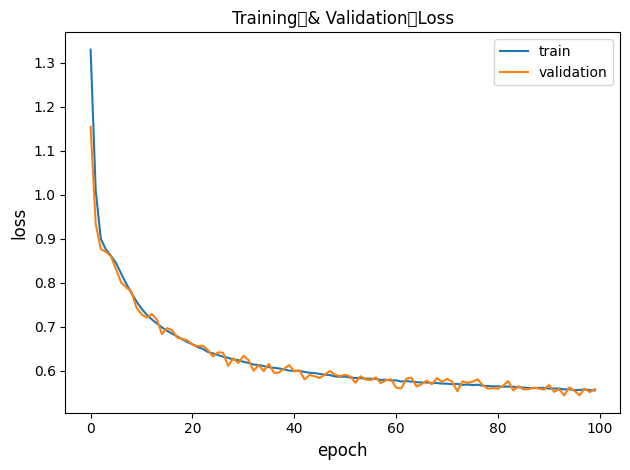

In [150]:
plot_loss_graph(DNN_loss_values, DNN_loss_values_v)